In [108]:
import numpy as np
import pandas as pd
import re
from random import randint
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import warnings 
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df2 = pd.read_csv('jobs.csv')

In [3]:
df2.head(2)

,Unnamed: 0,company,job_title,location,employment_type,seniority,job_category,salary_range,salary_type,num_of_applications,last_posted_date,expiry,responsibilities,requirements
0,0,KELLY SERVICES (SINGAPORE) PTE. LTD.,Systems Analyst (Agile),"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Contract,Professional,Information Technology,"$9,000to$13,500",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,Job Description To build scalable and reliab...,"Job Requirements Degree in Computer Science, ..."
1,1,KELLY SERVICES (SINGAPORE) PTE. LTD.,Systems Analyst (Agile),"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Contract,Professional,Information Technology,"$6,000to$9,000",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,Job Description To build scalable and reliab...,"Job Requirements Degree in Computer Science, ..."


In [4]:
# Drop the unnamed column
df2.drop(['Unnamed: 0'],axis=1,inplace=True)

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
company                1832 non-null object
job_title              1832 non-null object
location               1415 non-null object
employment_type        1832 non-null object
seniority              1803 non-null object
job_category           1832 non-null object
salary_range           1832 non-null object
salary_type            1640 non-null object
num_of_applications    1832 non-null object
last_posted_date       1832 non-null object
expiry                 1832 non-null object
responsibilities       1832 non-null object
requirements           1761 non-null object
dtypes: object(13)
memory usage: 203.2+ KB


In [6]:
# Check for missing values # 

def tab_missing_values(df):
    """
        Takes a data frame and tabulates all missing values by column 
    """    
    missing_df = df.isnull().sum(axis=0).reset_index()
    missing_df.columns = ['column_name', 'missing_count']

    # Filling factor is % of non null values in the column #
    missing_df['filling_factor'] = (df.shape[0] 
                                    - missing_df['missing_count']) / df.shape[0] * 100
    missing_df = missing_df.sort_values('filling_factor').reset_index(drop = True)

    return missing_df 


missing=tab_missing_values(df2)

# No missing values found # 
missing[missing['missing_count']>0]

,column_name,missing_count,filling_factor
0,location,585,70.75
1,salary_type,360,82.00
2,requirements,239,88.05
3,seniority,197,90.15
4,company,168,91.60
5,job_title,168,91.60
6,employment_type,168,91.60
7,job_category,168,91.60
8,salary_range,168,91.60
9,num_of_applications,168,91.60


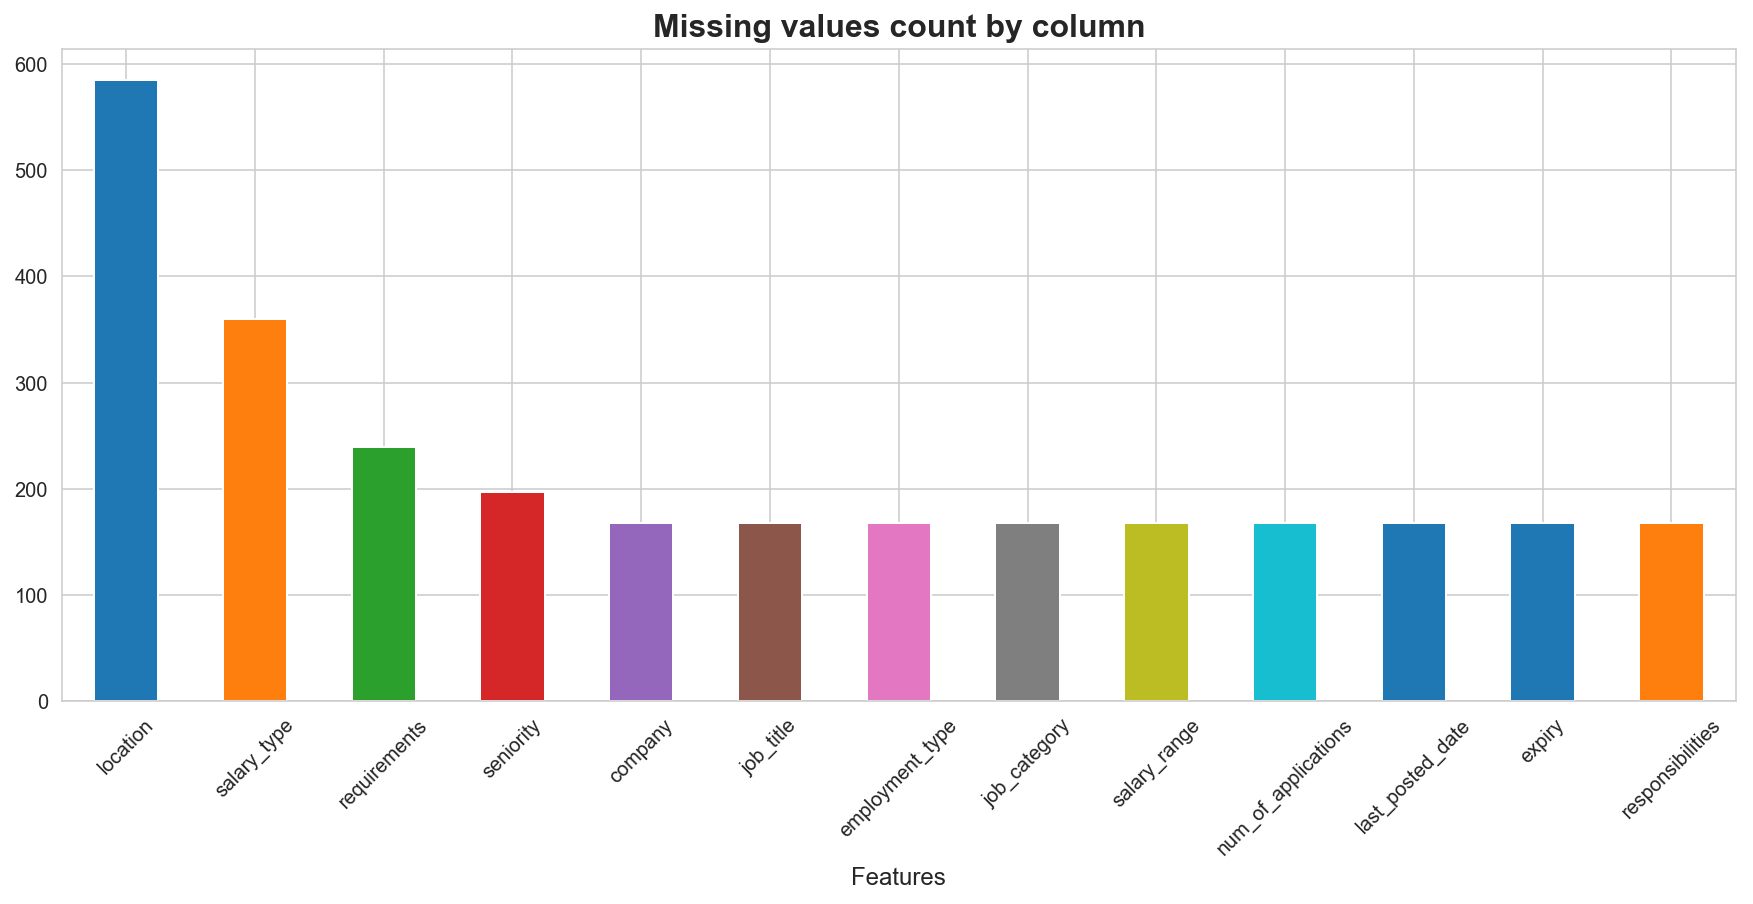

In [7]:
missing_df=tab_missing_values(df2)
plt.figure(figsize=(15,6))
f=missing_df['missing_count'].plot.bar()
f.set_xticklabels(missing_df['column_name'],rotation=45)
f.set_title('Missing values count by column',fontsize=16,fontweight='bold')
f.set_xlabel('Features',fontsize=12)
plt.show()

In [8]:
# drop rows where all fields are missing (broken links)
df2 = df2.dropna(how='all',inplace=False)

# drop rows where there is no salary information
df2 = df2.dropna(subset = ['salary_range'],inplace=False)

In [9]:
df2.head()

,company,job_title,location,employment_type,seniority,job_category,salary_range,salary_type,num_of_applications,last_posted_date,expiry,responsibilities,requirements
0,KELLY SERVICES (SINGAPORE) PTE. LTD.,Systems Analyst (Agile),"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Contract,Professional,Information Technology,"$9,000to$13,500",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,Job Description To build scalable and reliab...,"Job Requirements Degree in Computer Science, ..."
1,KELLY SERVICES (SINGAPORE) PTE. LTD.,Systems Analyst (Agile),"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Contract,Professional,Information Technology,"$6,000to$9,000",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,Job Description To build scalable and reliab...,"Job Requirements Degree in Computer Science, ..."
2,GOOGLE ASIA PACIFIC PTE. LTD.,"Data Science Lead, Large Customer Sales - Sing...","MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...",Full Time,Executive,Information Technology,"$7,700to$15,400",Monthly,3 applications,Posted 29 Jan 2019,Closing on 28 Feb 2019,Company overview: Google is not a conventional...,Minimum qualifications: - Bachelor’s degree in...
3,TRAKOMATIC PTE. LTD.,Data analyst,"ALICE@MEDIAPOLIS, 29 MEDIA CIRCLE 138565",Full Time,Professional,Information Technology,"$3,500to$4,500",Monthly,12 applications,Posted 29 Jan 2019,Closing on 28 Feb 2019,The Retail Data Analyst will lead and perform ...,"Requirements: A bachelor’s degree in math,..."
4,"VARIAN MEDICAL SYSTEMS PACIFIC, INC.",Business Data Analyst,NaN,Permanent,Fresh/entry level,"Consulting , Information Technology",Salary undisclosed,NaN,48 applications,Posted 29 Jan 2019,Closing on 28 Feb 2019,Position Summary & Core Responsibilities: Data...,Minimum Required Skills and Knowledge: Profic...


In [10]:
# df2 = df2.reset_index(drop=True,inplace=True)
# df2.head()
# print("shape:{}".format(df2.shape))

In [11]:
df2.head()

,company,job_title,location,employment_type,seniority,job_category,salary_range,salary_type,num_of_applications,last_posted_date,expiry,responsibilities,requirements
0,KELLY SERVICES (SINGAPORE) PTE. LTD.,Systems Analyst (Agile),"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Contract,Professional,Information Technology,"$9,000to$13,500",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,Job Description To build scalable and reliab...,"Job Requirements Degree in Computer Science, ..."
1,KELLY SERVICES (SINGAPORE) PTE. LTD.,Systems Analyst (Agile),"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Contract,Professional,Information Technology,"$6,000to$9,000",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,Job Description To build scalable and reliab...,"Job Requirements Degree in Computer Science, ..."
2,GOOGLE ASIA PACIFIC PTE. LTD.,"Data Science Lead, Large Customer Sales - Sing...","MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...",Full Time,Executive,Information Technology,"$7,700to$15,400",Monthly,3 applications,Posted 29 Jan 2019,Closing on 28 Feb 2019,Company overview: Google is not a conventional...,Minimum qualifications: - Bachelor’s degree in...
3,TRAKOMATIC PTE. LTD.,Data analyst,"ALICE@MEDIAPOLIS, 29 MEDIA CIRCLE 138565",Full Time,Professional,Information Technology,"$3,500to$4,500",Monthly,12 applications,Posted 29 Jan 2019,Closing on 28 Feb 2019,The Retail Data Analyst will lead and perform ...,"Requirements: A bachelor’s degree in math,..."
4,"VARIAN MEDICAL SYSTEMS PACIFIC, INC.",Business Data Analyst,NaN,Permanent,Fresh/entry level,"Consulting , Information Technology",Salary undisclosed,NaN,48 applications,Posted 29 Jan 2019,Closing on 28 Feb 2019,Position Summary & Core Responsibilities: Data...,Minimum Required Skills and Knowledge: Profic...


In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1832 entries, 0 to 1999
Data columns (total 13 columns):
company                1832 non-null object
job_title              1832 non-null object
location               1415 non-null object
employment_type        1832 non-null object
seniority              1803 non-null object
job_category           1832 non-null object
salary_range           1832 non-null object
salary_type            1640 non-null object
num_of_applications    1832 non-null object
last_posted_date       1832 non-null object
expiry                 1832 non-null object
responsibilities       1832 non-null object
requirements           1761 non-null object
dtypes: object(13)
memory usage: 200.4+ KB


In [13]:
# locate indexes of rows with salary as NaN
null_salary = df2.salary_range.isnull()
print('no. of missing target values: {}'. format(null_salary.sum()))

no. of missing target values: 0


In [14]:
# drop rows where salary is not disclosed
df2 = df2[df2.salary_range != "Salary undisclosed"]

In [15]:
# reset index
df2.reset_index(drop=True,inplace=True)

print("shape:{}".format(df2.shape))

shape:(1640, 13)


In [16]:
# locate indexes of rows with addresses as NaN
null_location = df2.location.isnull()
print('no. of missing address: {}'.format(null_location.sum()),'\n')

null_location_indexlist = [i for i,v in enumerate(list(null_location)) if v == True]
print(null_location_indexlist[0:10],'\n')

# examine rows with address as Nan
df2.iloc[null_location_indexlist,:]

# as these rows contain useful information, we will replace them with undisclosed
df2['location'].iloc[null_location_indexlist] = 'undisclosed'

no. of missing address: 344 

[15, 16, 21, 22, 26, 30, 52, 53, 64, 65] 



In [17]:
df2.head()

,company,job_title,location,employment_type,seniority,job_category,salary_range,salary_type,num_of_applications,last_posted_date,expiry,responsibilities,requirements
0,KELLY SERVICES (SINGAPORE) PTE. LTD.,Systems Analyst (Agile),"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Contract,Professional,Information Technology,"$9,000to$13,500",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,Job Description To build scalable and reliab...,"Job Requirements Degree in Computer Science, ..."
1,KELLY SERVICES (SINGAPORE) PTE. LTD.,Systems Analyst (Agile),"ASIA SQUARE TOWER 1, 8 MARINA VIEW 018960",Contract,Professional,Information Technology,"$6,000to$9,000",Monthly,0 application,Posted 30 Jan 2019,Closing on 01 Mar 2019,Job Description To build scalable and reliab...,"Job Requirements Degree in Computer Science, ..."
2,GOOGLE ASIA PACIFIC PTE. LTD.,"Data Science Lead, Large Customer Sales - Sing...","MARINA BAY FINANCIAL CENTRE, 8 MARINA BOULEVAR...",Full Time,Executive,Information Technology,"$7,700to$15,400",Monthly,3 applications,Posted 29 Jan 2019,Closing on 28 Feb 2019,Company overview: Google is not a conventional...,Minimum qualifications: - Bachelor’s degree in...
3,TRAKOMATIC PTE. LTD.,Data analyst,"ALICE@MEDIAPOLIS, 29 MEDIA CIRCLE 138565",Full Time,Professional,Information Technology,"$3,500to$4,500",Monthly,12 applications,Posted 29 Jan 2019,Closing on 28 Feb 2019,The Retail Data Analyst will lead and perform ...,"Requirements: A bachelor’s degree in math,..."
4,INTELLECT MINDS PTE. LTD.,Data Engineer,"ANSON CENTRE, 51 ANSON ROAD 079904",Full Time,Executive,Information Technology,"$5,000to$7,000",Monthly,1 application,Posted 29 Jan 2019,Closing on 28 Feb 2019,Company Overview Intellect Minds is a Singapor...,Qualifications • Advanced working SQL knowledg...


In [18]:
# locate indexes of rows with requirements as NaN
null_seniority = df2.seniority.isnull()
print('no. of missing seniority {}'.format(null_seniority.sum()), '\n')

null_seniority_indexlist = [i for i,v in enumerate(list(null_seniority)) if v==True]
print(null_seniority_indexlist[0:10],'\n')

# taking a look at rows with requirements as Nan
df2.iloc[null_seniority_indexlist,:]

# changing null values to undisclosed
df2['seniority'].iloc[null_seniority_indexlist] = 'undisclosed'

no. of missing seniority 3 

[612, 1081, 1441] 



In [19]:
# convert all string elements in jobs df to lowercase
for col_name in list(df2.columns.values):
    df2[col_name] = df2[col_name].map(lambda x: x.lower() if type(x) == str else x)

In [20]:
df2.head()

,company,job_title,location,employment_type,seniority,job_category,salary_range,salary_type,num_of_applications,last_posted_date,expiry,responsibilities,requirements
0,kelly services (singapore) pte. ltd.,systems analyst (agile),"asia square tower 1, 8 marina view 018960",contract,professional,information technology,"$9,000to$13,500",monthly,0 application,posted 30 jan 2019,closing on 01 mar 2019,job description to build scalable and reliab...,"job requirements degree in computer science, ..."
1,kelly services (singapore) pte. ltd.,systems analyst (agile),"asia square tower 1, 8 marina view 018960",contract,professional,information technology,"$6,000to$9,000",monthly,0 application,posted 30 jan 2019,closing on 01 mar 2019,job description to build scalable and reliab...,"job requirements degree in computer science, ..."
2,google asia pacific pte. ltd.,"data science lead, large customer sales - sing...","marina bay financial centre, 8 marina boulevar...",full time,executive,information technology,"$7,700to$15,400",monthly,3 applications,posted 29 jan 2019,closing on 28 feb 2019,company overview: google is not a conventional...,minimum qualifications: - bachelor’s degree in...
3,trakomatic pte. ltd.,data analyst,"alice@mediapolis, 29 media circle 138565",full time,professional,information technology,"$3,500to$4,500",monthly,12 applications,posted 29 jan 2019,closing on 28 feb 2019,the retail data analyst will lead and perform ...,"requirements: a bachelor’s degree in math,..."
4,intellect minds pte. ltd.,data engineer,"anson centre, 51 anson road 079904",full time,executive,information technology,"$5,000to$7,000",monthly,1 application,posted 29 jan 2019,closing on 28 feb 2019,company overview intellect minds is a singapor...,qualifications • advanced working sql knowledg...


In [21]:
# feature engineering - salary range column
# replace the split lower and upper range, remove $ and , signs

salary_list = df2['salary_range'].map(lambda x: str(x).replace('to',' ').replace('$','').replace(',','').split())
lower = []
upper = []

for left_col in range(len(salary_list)):
    lower.append(float(salary_list[left_col][0]))
    
for right_col in range(len(salary_list)):
    if len(salary_list[right_col]) == 1:
        upper.append(np.nan)
    else:
        upper.append(float(salary_list[right_col][1]))

# standardizing salary periodicity as monthly for all salaries and calculate salaries as such
salary_lower = [round(v/12,2) if df2['salary_type'][i] == 'annually' else v for i,v in enumerate(lower)]
salary_upper = [round(v/12,2) if df2['salary_type'][i] == 'annually' else v for i,v in enumerate(upper)]

# concat two new cols to jobs df
df2['salary_lower_mth_num'] = salary_lower
df2['salary_upper_mth_num'] = salary_upper 

In [22]:
# include the mid value of salary range
df2['salary_mid_mth_num'] = (df2.salary_lower_mth_num+df2.salary_upper_mth_num)/2

print('df shape: {}'.format(df2.shape))

df shape: (1640, 16)


In [23]:
# remove duplicates in df
df2 = df2.drop_duplicates()
df2.reset_index(drop=True,inplace=True)

print('df shape: {}'.format(df2.shape))

df shape: (1633, 16)


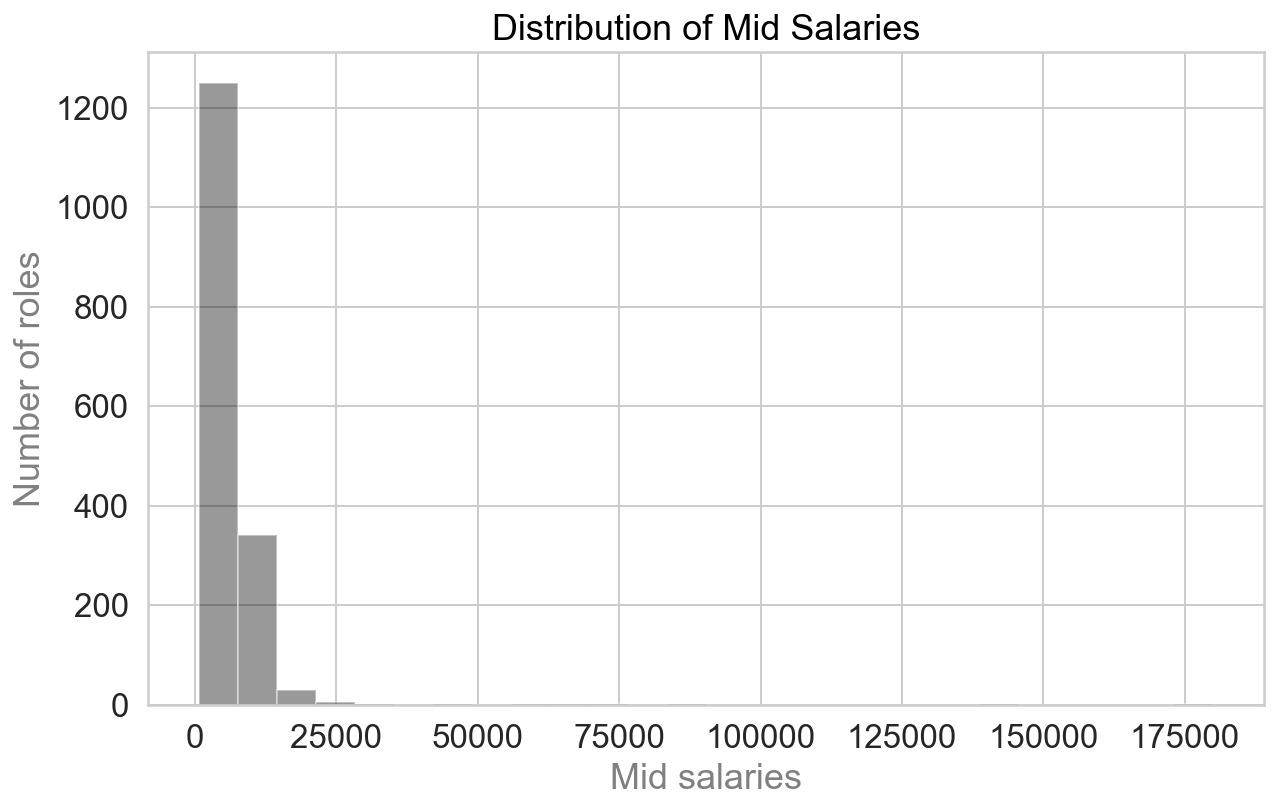

In [24]:
# distribution of mid salaries
sns.set(rc={'figure.figsize':(10,6)},style='whitegrid',font_scale=1.5)
sns.distplot(df2['salary_mid_mth_num'],kde=False,color='black',bins=26,).set_title('Distribution of Mid Salaries',color='Black')
plt.ylabel('Number of roles',rotation=90,color='gray')
plt.xlabel('Mid salaries',rotation=0,color='gray');

In [25]:
median_salary = df2['salary_mid_mth_num'].median()
mean_salary = df2['salary_mid_mth_num'].mean()
print('median_salary: {}'.format(median_salary))
print('mean_salary: {}'.format(mean_salary))

median_salary: 5750.0
mean_salary: 6542.626662584202


In [26]:
# We shall define salaries above the median salary 

In [27]:
df2['salary_mid_mth_num'].describe()

count      1633.000000
mean       6542.626663
std        7454.477223
min         650.000000
25%        3750.000000
50%        5750.000000
75%        7500.000000
max      180000.000000
Name: salary_mid_mth_num, dtype: float64

In [28]:
# there seems to be 8 jobs with salaries above 30,000 per month

df2[df2['salary_mid_mth_num'] >30000].count()

company                 8
job_title               8
location                8
employment_type         8
seniority               8
job_category            8
salary_range            8
salary_type             8
num_of_applications     8
last_posted_date        8
expiry                  8
responsibilities        8
requirements            8
salary_lower_mth_num    8
salary_upper_mth_num    8
salary_mid_mth_num      8
dtype: int64

In [43]:
# we will drop these outliers and reset index
df2 = df2[df2['salary_mid_mth_num'] <30000]
df2.reset_index(drop=True,inplace=True)
print("shape:{}".format(df2.shape))

shape:(1625, 17)


In [30]:
# clean up the employment types
df2.employment_type.unique()

array(['contract', 'full time', 'permanent', 'permanent, full time',
       'permanent, contract', 'contract, full time', 'temporary',
       'temporary, contract', 'permanent, contract, full time',
       'part time, permanent, contract, freelance, full time',
       'contract, internship', 'freelance', 'temporary, full time',
       'part time, permanent, contract, full time',
       'part time, temporary, contract, full time',
       'freelance, full time, flexi work',
       'temporary, contract, full time', 'internship',
       'permanent, temporary, contract', 'part time',
       'part time, full time', 'full time, flexi work',
       'part time, permanent, full time', 'flexi work',
       'part time, temporary, contract, full time, flexi work',
       'part time, permanent, contract, freelance, flexi work',
       'part time, permanent, full time, flexi work',
       'part time, permanent, freelance, full time, internship'],
      dtype=object)

In [31]:
import re

def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [32]:
# arrange the job columns
employment_type_replace = {'permanent':"full time",
                           'part time': "part time and others",
                           'permanent, full time': "full time",
        'permanent, contract' : "contract", 
        'contract, full time': "full time", 
        'temporary':"part time and others",
        'temporary, contract':"contract", 
        'permanent, contract, full time': "full time",
        'part time, permanent, contract, freelance, full time': "full time",
        'contract, internship':'part time and others', 
        'freelance':"part time and others", 
        'temporary, full time': "full time",
        'part time, permanent, contract, full time': "full time",
        'part time, temporary, contract, full time': "full time",
        'freelance, full time, flexi work': "full time",
        'temporary, contract, full time': "full time", 
        'internship':"part time and others",
        'permanent, temporary, contract': "contract", 
        'part time': "part time and others",
        'part time, full time': "full time", 
        'full time, flexi work': "full time",
        'part time, permanent, full time': "full time", 
        'flexi work': "part time and others",
        'part time, temporary, contract, full time, flexi work':"full time",
        'part time, permanent, contract, freelance, flexi work':"part time and others",
        'part time, permanent, full time, flexi work':"full time",
        'part time, permanent, freelance, full time, internship':"full time"}

df2['employment_type']=df2['employment_type'].apply(lambda x : str(x))
df2['employment_type']=df2['employment_type'].apply(lambda x : replace(x, employment_type_replace))
#check the value_counts of the job columns
df2['employment_type'].value_counts(dropna=False)

full time               1391
contract                 214
part time and others      20
Name: employment_type, dtype: int64

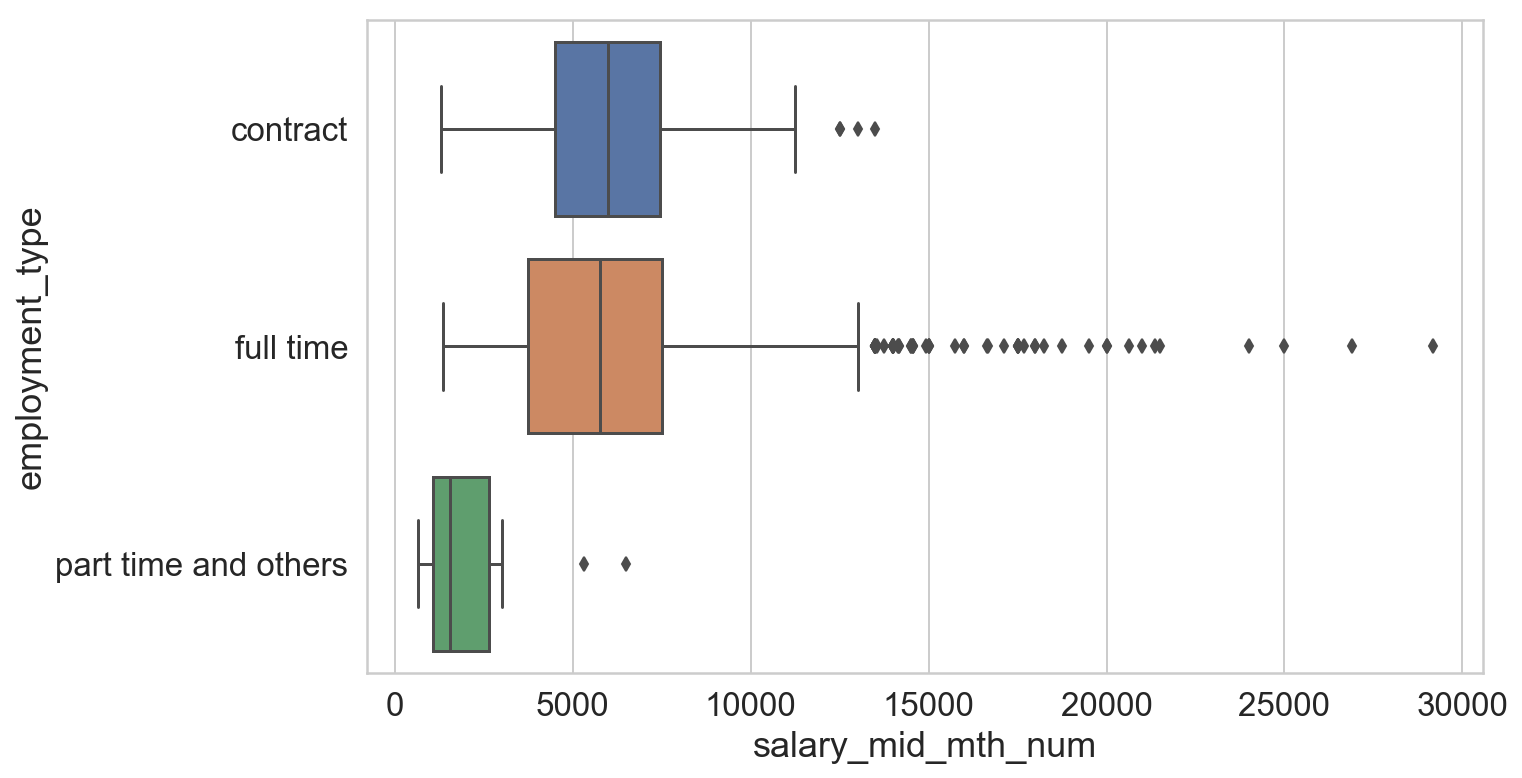

In [35]:
#Create a figure instance
fig = plt.figure(figsize=(10,6))

#Create an axes instance
ax = fig.gca()

#Create the boxplot
sns.boxplot(x=df2['salary_mid_mth_num'], y=df2['employment_type'], orient="h")

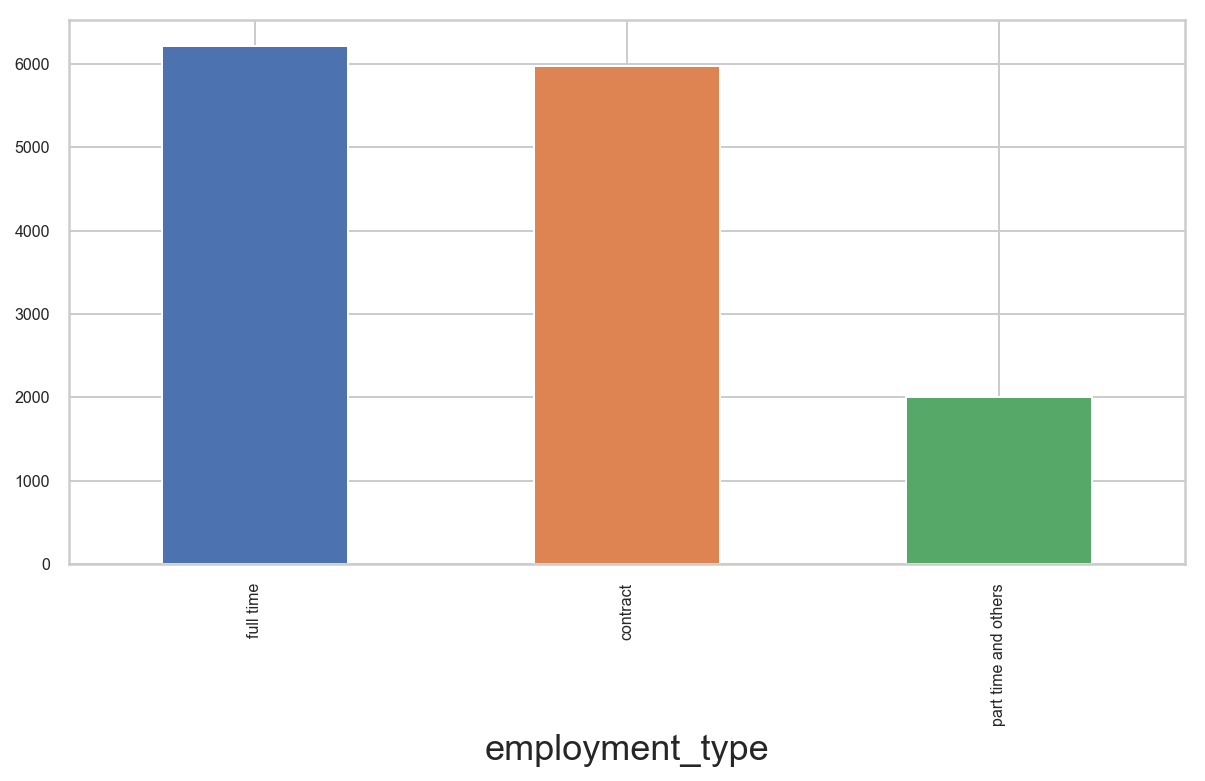

In [36]:
df2.groupby(['employment_type'])['salary_mid_mth_num'].mean().sort_values(ascending=False).plot(kind='bar', 
            figsize=(10,5), 
            fontsize=8)

In [ ]:
# Full time employment provides the highest remuneration followed by contract roles

In [89]:
# Clean up the responsibilities column
import re
df2["responsibilities"] = df2["responsibilities"].apply(lambda x : str(x))
df2["responsibilities"] = df2["responsibilities"].apply(lambda x : re.sub('\W+',' ', x).lower()) #remove punctuations and lower text
df2["responsibilities"] = df2["responsibilities"].apply(lambda x: " ".join(x.split())) #remove additional spaces
df2["responsibilities"].values

array(['job description to build scalable and reliable batch and streaming data pipelines to support data analytics applications',
       'job description to build scalable and reliable batch and streaming data pipelines to support data analytics applications',
       'company overview google is not a conventional company and we don t intend to become one true we share attributes with the world s most successful organizations a focus on innovation and smart business practices comes to mind but even as we continue to grow we re committed to retaining a small company feel at google we know that every employee has something important to say and that every employee is integral to our success we provide individually tailored compensation packages that can be comprised of competitive salary bonus and equity components along with the opportunity to earn further financial bonuses and rewards googlers thrive in small focused teams and high energy environments believe in the ability of technolog

In [90]:
# Clean up the requirements column
import re
df2["requirements"] = df2["requirements"].apply(lambda x : str(x))
df2["requirements"] = df2["requirements"].apply(lambda x : re.sub('\W+',' ', x).lower()) #remove punctuations and lower text
df2["requirements"] = df2["requirements"].apply(lambda x: " ".join(x.split())) #remove additional spaces
df2["requirements"].values

array(['job requirements degree in computer science computer engineering or equivalent at least 5 8 years of experience building scalable and reliable batch and streaming data pipeline strong competency in sql python programming linux shell scripting knowledge of data management etl tool services from amazon web services e g athena glue kinesys redshift google cloud platform e g big query bi tools e g sisense tableau would be an advantage able to work independently with minimal supervision good verbal and written communication skills',
       'job requirements degree in computer science computer engineering or equivalent at least 5 8 years of experience building scalable and reliable batch and streaming data pipeline strong competency in sql python programming linux shell scripting knowledge of data management etl tool services from amazon web services e g athena glue kinesys redshift google cloud platform e g big query bi tools e g sisense tableau would be an advantage able to work in

## Create decision boundary based on median of salary_mid_mth_num
- High salary is assigned to target if salary_mid_mth_num is greater than or equal to median of salary_mid_mth_num

- Lower salary is assigned otherwise

In [47]:
# Create a new feature called target with decision boundaries aboved
target = []

for i in range(df2.shape[0]):
    if df2['salary_mid_mth_num'][i]>= np.median(df2['salary_mid_mth_num']):
        target.append(1)
    else:
        target.append(0)
        
df2['target'] = target

print('number of jobs above median: {}'.format(len(target)),'\n')

df2['target'].value_counts()

number of jobs above median: 1625 



1    836
0    789
Name: target, dtype: int64

In [55]:
# Calculate the baseline
if df2['target'].value_counts()[0] > df2['target'].value_counts()[1]:
    print('baseline is class 0: {}'.format(df2['target'].value_counts()[0]/len(df2)))
else:
    print('baseline is class 1: {}'.format(df2['target'].value_counts()[1]/len(df2)))

baseline is class 1: 0.5144615384615384


In [56]:
# Save df2 to .csvfile
df2.to_csv('df2.csv',index=False)

In [99]:
# Create train test split using job title
X = df2.job_title
y = df2.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline to verctorize and use random forest classifier
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=100,random_state=42))
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("Random Forest score: {}".format(pipeline.score(X_test,y_test)))

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))

print(classification_report((y_test),predicted))

X_train shape: (1137,) 

Random Forest score: 0.7827868852459017
cross-validation score: 0.748
             precision    recall  f1-score   support

          0       0.79      0.74      0.77       233
          1       0.78      0.82      0.80       255

avg / total       0.78      0.78      0.78       488



In [101]:
# Create train test split
X = df2.job_title
y = df2.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline using logistic regression
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("logistic regression score: {}".format(pipeline.score(X_test,y_test)))  

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))
print(classification_report((y_test),predicted))

X_train shape: (1137,) 

logistic regression score: 0.7766393442622951
cross-validation score: 0.745
             precision    recall  f1-score   support

          0       0.79      0.73      0.76       233
          1       0.77      0.82      0.79       255

avg / total       0.78      0.78      0.78       488



In [102]:
# Create train test split using requirements
X = df2.requirements
y = df2.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline to verctorize and use random forest classifier
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=100,random_state=42))
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("Random Forest score: {}".format(pipeline.score(X_test,y_test)))

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))
print(classification_report((y_test),predicted))

X_train shape: (1137,) 

Random Forest score: 0.7725409836065574
cross-validation score: 0.767
             precision    recall  f1-score   support

          0       0.77      0.76      0.76       233
          1       0.78      0.79      0.78       255

avg / total       0.77      0.77      0.77       488



In [103]:
# Create train test split
X = df2.requirements
y = df2.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline using logistic regression
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("logistic regression score: {}".format(pipeline.score(X_test,y_test)))  

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))
print(classification_report((y_test),predicted))

X_train shape: (1137,) 

logistic regression score: 0.7889344262295082
cross-validation score: 0.779
             precision    recall  f1-score   support

          0       0.82      0.71      0.76       233
          1       0.77      0.86      0.81       255

avg / total       0.79      0.79      0.79       488



In [104]:
# Create train test split using requirements
X = df2.responsibilities
y = df2.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline to verctorize and use random forest classifier
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=100,random_state=42))
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("Random Forest score: {}".format(pipeline.score(X_test,y_test)))

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))

X_train shape: (1137,) 

Random Forest score: 0.7766393442622951
cross-validation score: 0.77


In [105]:
# Create train test split
X = df2.responsibilities
y = df2.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline using logistic regression
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("logistic regression score: {}".format(pipeline.score(X_test,y_test)))  

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))
print(classification_report((y_test),predicted))

X_train shape: (1137,) 

logistic regression score: 0.7848360655737705
cross-validation score: 0.763
             precision    recall  f1-score   support

          0       0.79      0.74      0.77       233
          1       0.78      0.82      0.80       255

avg / total       0.79      0.78      0.78       488



In [ ]:
# Logistic regression on job requirements seem to give the best score of 0.779

## Question 2

In [115]:
# Extract job titles with the words data scientist in them

data_index = []

for i in range(df2.shape[0]):
    try:
        if re.findall(r'\bdata scientist\b',df2['job_title'][i])[0] == 'data scientist':
            data_index.append(i)
    except:
        pass

    
print('len data_index: {}'.format(len(data_index)),'\n')

df2.iloc[data_index,:]['job_title'].value_counts()

len data_index: 41 



data scientist                                                                28
senior data scientist                                                          3
lead data scientist                                                            2
associate  /  senior data scientist                                            1
data scientist (62913)                                                         1
data scientist - information technology                                        1
senior  /  staff data scientist                                                1
data scientist  /  application production engineer                             1
avp, data scientist, business analytics, consumer banking group (180004xi)     1
data scientist / engineer                                                      1
senior analytics manager - data scientist                                      1
Name: job_title, dtype: int64

## Create a decision boundary based on job titles that contain the word 'data scientist'
    - Class of 1 is assigned to target if job title contains the word 'data scientist'
    
    - Class of 0 is assigned otherwise

In [117]:
# concat 'target_jobtitle' column to dfs as target for job titles
df2['target_jobtitle'] = 0

df2.loc[data_index,'target_jobtitle'] = 1

print('shape: {}'.format(df2.shape))

shape: (1625, 19)


In [128]:
jobtitle1 = df2[df2['target_jobtitle'] == 1]
jobtitle0 = df2[df2['target_jobtitle'] == 0]

print('jobtitle1 shape: {}'.format(jobtitle1.shape),'\n')
print('jobtitle0 shape: {}'.format(jobtitle0.shape),'\n')

# oversample jobtitle1 to address class imbalance
jobtitle1_over = jobtitle1.sample(1584,replace=True)

jobtitle_over = pd.concat([jobtitle0,jobtitle1_over],axis=0)
jobtitle_over.reset_index(drop=True,inplace=True)

print(jobtitle_over['target_jobtitle'].value_counts(),'\n')

jobtitle1 shape: (41, 19) 

jobtitle0 shape: (1584, 19) 

1    1584
0    1584
Name: target_jobtitle, dtype: int64 



In [129]:
# Create train test split using requirements
X = jobtitle_over.requirements
y = jobtitle_over.target_jobtitle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline to verctorize and use random forest classifier
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=100,random_state=42))
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("Random Forest score: {}".format(pipeline.score(X_test,y_test)))

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))
print(classification_report((y_test),predicted))

X_train shape: (2217,) 

Random Forest score: 0.9863301787592008
cross-validation score: 0.985
             precision    recall  f1-score   support

          0       0.97      1.00      0.99       494
          1       1.00      0.97      0.99       457

avg / total       0.99      0.99      0.99       951



In [131]:
# Create train test split using requirements
X = jobtitle_over.requirements
y = jobtitle_over.target_jobtitle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline using logistic regression
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("logistic regression score: {}".format(pipeline.score(X_test,y_test)))  

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))
print(classification_report((y_test),predicted))

X_train shape: (2217,) 

logistic regression score: 0.9779179810725552
cross-validation score: 0.981
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       494
          1       0.98      0.97      0.98       457

avg / total       0.98      0.98      0.98       951



In [132]:
# Create train test split using requirements
X = jobtitle_over.responsibilities
y = jobtitle_over.target_jobtitle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline to verctorize and use random forest classifier
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('rf', RandomForestClassifier(n_estimators=100,random_state=42))
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("Random Forest score: {}".format(pipeline.score(X_test,y_test)))

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))
print(classification_report((y_test),predicted))

X_train shape: (2217,) 

Random Forest score: 0.9989484752891693
cross-validation score: 0.999
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       494
          1       1.00      1.00      1.00       457

avg / total       1.00      1.00      1.00       951



In [133]:
# Create train test split using requirements
X = jobtitle_over.responsibilities
y = jobtitle_over.target_jobtitle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print('X_train shape: {}'.format(X_train.shape),'\n')

# Create a pipeline using logistic regression
cvt = CountVectorizer(stop_words='english')
pipeline = Pipeline([
    ('vect', cvt),
    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
])

pipeline.fit(X_train,y_train)
predicted = pipeline.predict(X_test)
print("logistic regression score: {}".format(pipeline.score(X_test,y_test)))  

#cross validate
scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print('cross-validation score: {}'.format(round(np.mean(scores),3), round(np.std(scores),3)))
print(classification_report((y_test),predicted))

X_train shape: (2217,) 

logistic regression score: 0.9894847528916929
cross-validation score: 0.991
             precision    recall  f1-score   support

          0       1.00      0.98      0.99       494
          1       0.98      1.00      0.99       457

avg / total       0.99      0.99      0.99       951



Based on the analysis of the predictive models used above, requirements and responsibilities of a 
job has the best predictive value of whether the job is high or low paying, which is defined 
by the median salary of all data related jobs extracted from the URL. 